In [14]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib


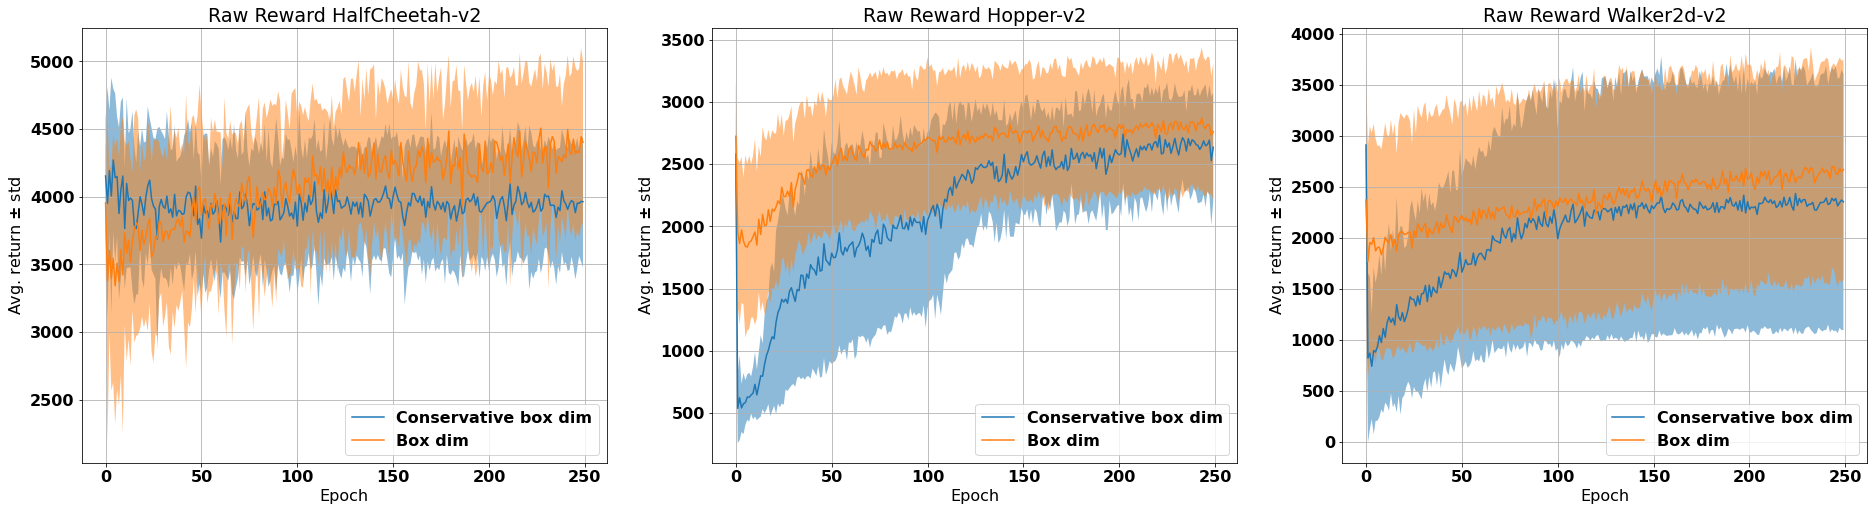

In [15]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]#, "Ant-v2"]
init_names = ["identity", "madodiv", "identity"]#, "identity"]

font = {'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, len(env_names), figsize=(32,8))

i = 0 
for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    ax[i].plot(means.T)
    ax[i].legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        ax[i].fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    ax[i].set_title(f"Raw Reward {env_name}")
    ax[i].set_ylabel(r"Avg. return $\pm$ std")
    ax[i].set_xlabel(r"Epoch")
    ax[i].grid()
    i+=1
    
#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.legend([i for i in range(10)])
#         plt.title(exp_name)
#         plt.figure()

running build_ext


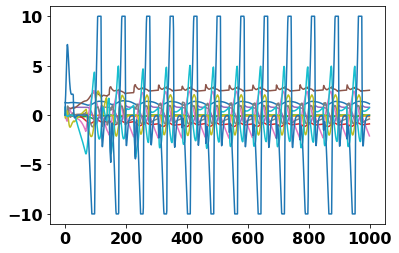

In [4]:
env_name = "Hopper-v2"
env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

obs, acts, rews, _  = do_rollout(env, policy_dict['identity'][7])
plt.plot(obs);

In [12]:
seed = 2; delta = .01
iden_mesh = BoxMesh(delta); iden_l = []
mdim_mesh = BoxMesh(delta); mdim_l = []

iden_policy = policy_dict['identity'][seed]
mdim_policy = policy_dict['mdim_div'][seed]

batch_size = 128

def do_mesh_rollout(trial_num):
    env.seed(trial_num)
    torch.manual_seed(trial_num)
    obs, acts, rews, _  = do_rollout(env, iden_policy)
    iden_obs = (obs - iden_policy.state_means)/(iden_policy.state_std)
    
    obs, acts, rews, _  = do_rollout(env, mdim_policy)
    mdim_obs = (obs - mdim_policy.state_means)/(mdim_policy.state_std)
    
    return iden_obs, mdim_obs
    

In [13]:
from torch.multiprocessing import Pool
with Pool() as pool:

    for i in range(0, 100):
        for j, res in enumerate(pool.imap(do_mesh_rollout, range(i*batch_size, i*batch_size+batch_size))):
            iden_obs, mdim_obs = res
           
            for o in iden_obs:
                if o in iden_mesh:
                    iden_mesh[o]+=1
                else:
                    iden_mesh[o]=1

            for o in mdim_obs:
                if o in mdim_mesh:
                    mdim_mesh[o]+=1
                else:
                    mdim_mesh[o]=1
                    
        iden_l.append(len(iden_mesh)); mdim_l.append(len(mdim_mesh))
        print(f"i; {i}, iden: {len(iden_mesh)}, mdim: {len(mdim_mesh)}, ratio: {len(mdim_mesh)/len(iden_mesh)}")


i; 0, iden: 127358, mdim: 98350, ratio: 0.772232604155216
i; 1, iden: 253607, mdim: 175184, ratio: 0.6907695765495432
i; 2, iden: 379120, mdim: 240856, ratio: 0.6353028064992614
i; 3, iden: 503538, mdim: 298604, ratio: 0.5930118481624028
i; 4, iden: 627116, mdim: 354964, ratio: 0.5660260621639378
i; 5, iden: 749542, mdim: 407203, ratio: 0.5432690896574175
i; 6, iden: 871830, mdim: 457214, ratio: 0.5244302214881341
i; 7, iden: 992645, mdim: 504084, ratio: 0.507819008809796
i; 8, iden: 1112398, mdim: 548536, ratio: 0.49311127851722136
i; 9, iden: 1231673, mdim: 594412, ratio: 0.48260536684655747
i; 10, iden: 1350540, mdim: 636454, ratio: 0.47125890384586905
i; 11, iden: 1467517, mdim: 677656, ratio: 0.461770459899272
i; 12, iden: 1583992, mdim: 718876, ratio: 0.4538381506977308
i; 13, iden: 1699833, mdim: 758221, ratio: 0.44605617140036696
i; 14, iden: 1815072, mdim: 795957, ratio: 0.4385264055640768
i; 15, iden: 1930682, mdim: 832508, ratio: 0.4311989234892126
i; 16, iden: 2044873, mdim

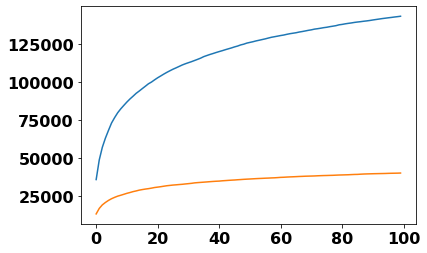

In [11]:
plt.plot(iden_l)
plt.plot(mdim_l)

In [88]:
6*28

168

In [ ]:
lin_begin = 300
xdata = np.array(range(lin_begin,len(mdim_l)))
ydata = np.array(mdim_l[lin_begin:])

# Fit a curve to the log log line
def f(x, m, b):
    return m * x + b

popt, pcov = opt.curve_fit(f, xdata, ydata)

x = np.linspace(lin_begin,len(mdim_l))
y = popt[0]*x + popt[1]

plt.plot(x,y, 'x-')
plt.plot(mdim_l)

print(popt)